In [1]:
import syndat
import os
import numpy as np
from matplotlib.pyplot import *
# import nuctools as nuc
import pandas as pd
import scipy.linalg as spla

In [2]:
%matplotlib widget

### This notebook uses the syndat program to create a synthetic realization of the Ta181 transmission data set using ENDF parameters and verifies the results against real data reduced by Brown, et. al.

Because the we are using the endf evaluated parameters, we are skipping the steps to generate resonance paremeters and theoretical tranmission with syndat. Rather, we will just read out the sammy calculated endf cross section and take that as the true theoretical cross section.

In [3]:
# import Jesse's reduced data and look at it
jb_df = pd.read_csv("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_reduction_data.csv", index_col='Unnamed: 0')
jb_cov = np.load("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_cov.npy")
jb_df

,e,trans,tof,cs,cts,dcs,bs,dbs,co,dco,bo,dbo,bfit
0,88416.045425,0.571458,11.8816,580.950003,8793.047220,6.195396,187.842997,0.1,1166.229542,12.078151,478.327440,0.1,3.160622e+02
1,73637.283950,0.538982,12.7008,1814.838405,27468.731770,10.950114,180.492386,0.1,3491.405805,20.898187,459.121847,0.1,3.030060e+02
2,62276.564917,0.520194,13.5200,1959.652939,29660.591700,11.378611,173.445420,0.1,3874.441705,22.014712,440.709615,0.1,2.904892e+02
3,53355.681453,0.531282,14.3392,1707.443607,25843.243300,10.621182,166.689556,0.1,3323.128704,20.388347,423.057969,0.1,2.784894e+02
4,46222.889688,0.502918,15.1584,1241.464506,18790.353680,9.056634,160.212768,0.1,2556.093274,17.881205,406.135492,0.1,2.669854e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15910,3.015622,0.417764,1468.1888,18.485957,279.796699,1.105149,9.900000,0.1,33.952195,2.060831,13.400000,0.1,8.506101e-31
15911,3.012251,0.349083,1469.0080,17.332079,262.332019,1.070102,9.900000,0.1,34.690271,2.083110,13.400000,0.1,8.154724e-31
15912,3.008887,0.297559,1469.8272,15.890513,240.513011,1.024634,9.900000,0.1,33.532182,2.048044,13.400000,0.1,7.817863e-31
15913,3.005528,0.500051,1470.6464,18.931344,286.537910,1.118383,9.900000,0.1,31.460858,1.983781,13.400000,0.1,7.494916e-31


In [4]:
opendata = '/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/rpi-open-ta181.csv'
sammy_xs = "/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JEFF_eval/SAMMY.LST" # '/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JEFF_eval/SAMMY.LST'

# JBrown_lst = syndat.sammy_interface.readlst('../synthetic_data/Ta181/JB_sol/SAMMY_JBsol.LST')
# # calc tof using t0 and distance
# JBrown_lst['tof'] = syndat.exp_effects.e_to_t(JBrown_lst.E, 35.185, True)*1e6+3.326



In [5]:
# generation/reduction options
perform_methods = False
add_noise = False
default_exp = True

experiment = syndat.experiment(perform_methods, default_exp, add_noise, opendata, sammy_xs, E_limits=(3,100000))
# experiment.get_odat(opendata)


## Look into the stratification of data points

This is a product of the poisson noise sampling at low counts. While the stucture is seen vaguely in the real data, it is significantly less. This is likely due to the fact that that the real data is monitor normalized. To investigate this, I will increase the number of counts significantly before adding poisson noise. Then "monitor normalize" the number of counts back down to a the same magnitude and see if the structure looks more correct. The process will be as follows:
1. Run the experiment without adding noise to the counts
2. multiply the counts by a factor
3. add poisson noise to the counts
4. renormalize the noisy counts to the proper magnitude (divide by same factor)

In [31]:
experiment.get_odat(opendata)
experiment.get_bkg()
experiment.get_theoretical(sammy_xs)
experiment.generate_sdat(False)

clean_count_data = experiment.sdat.c
tof = experiment.sdat.tof
direct_poisson = syndat.exp_effects.pois_noise(clean_count_data)
monitor_corrected = syndat.exp_effects.pois_noise(clean_count_data*10)/10

experiment.sdat['c'] = monitor_corrected
experiment.sdat['dc'] = np.sqrt(monitor_corrected)

experiment.reduce()

In [32]:

# avg, par = syndat.sammy_interface.read_sammy_par("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JEFF_eval/SAMNDF.PAR", False)
# # experiment.odat
# samtools_array = syndat.sammy_interface.create_samtools_array_from_DF(par,False)
# syndat.sammy_interface.samtools_fmtpar(samtools_array, "/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JEFF_eval/vary_parm.par")

In [33]:
# put eveything in a similarly structured dataframe
syndat_df = pd.DataFrame({
    'e' : experiment.odat.E,
    'trans': experiment.trans.exp_trans,
    'theo': experiment.trans.theo_trans,
    'tof': experiment.trans.tof,
    'cs' : experiment.sdat.cps,
    'theo_cts':experiment.sdat.theo_cts,
    'cts': experiment.sdat.c,
    'dcs': experiment.sdat.dcps,
    'bs' : experiment.redpar.val.ks*experiment.Bi+experiment.redpar.val.b0s,
    'dbs': np.array([0.1]*len(experiment.odat.E)),
    'co' : experiment.odat.cps,
    'dco': experiment.odat.dcps,
    'bo' : experiment.redpar.val.ko*experiment.Bi+experiment.redpar.val.b0o,
    'dbo': np.array([0.1]*len(experiment.odat.E))
    # 'bfit': exp_f(trans1.open_data.tof,A,B)
})
syndat_df= syndat_df[::-1].reset_index(drop=True)
eLimits = (3,100000)
syndat_df = syndat_df[(syndat_df.e>eLimits[0])&(syndat_df.e<eLimits[1])].reset_index(drop=True)
syndat_df.sort_values('tof', inplace=True)
display(syndat_df)


,e,trans,theo,tof,cs,theo_cts,cts,dcs,bs,dbs,co,dco,bo,dbo
15914,88416.046104,0.624339,0.623646,11.881600,617.194339,4931.288591,4935.1,8.785651,187.811774,0.1,1165.985442,12.075623,478.245861,0.1
15913,73637.284515,0.619088,0.619191,12.700800,2057.310296,16452.800898,16450.3,16.040315,180.459799,0.1,3490.675029,20.893813,459.036704,0.1
15912,62276.565395,0.615488,0.615699,13.520000,2286.386682,18287.801189,18282.0,16.909775,173.411635,0.1,3873.630756,22.010104,440.621340,0.1
15911,53355.681863,0.612021,0.612894,14.339200,1941.190067,15542.027724,15521.8,15.581061,166.654727,0.1,3322.433149,20.384080,422.966968,0.1
15910,46222.890043,0.611344,0.610590,15.158400,1474.270436,11775.343329,11788.3,13.578493,160.177039,0.1,2555.558265,17.877463,406.042140,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,3.015622,0.321035,0.351186,1468.188682,16.495701,136.853144,131.9,1.436311,9.900000,0.1,33.945088,2.060400,13.400000,0.1
3,3.012251,0.399810,0.352292,1469.008106,18.409152,139.113418,147.2,1.517329,9.900000,0.1,34.683010,2.082674,13.400000,0.1
2,3.008887,0.374962,0.353389,1469.827230,17.446173,136.028367,139.5,1.477111,9.900000,0.1,33.525163,2.047616,13.400000,0.1
1,3.005528,0.345931,0.354478,1470.646456,16.145527,130.333954,129.1,1.420984,9.900000,0.1,31.454273,1.983366,13.400000,0.1


Text(0, 0.5, '$Counts/second$')

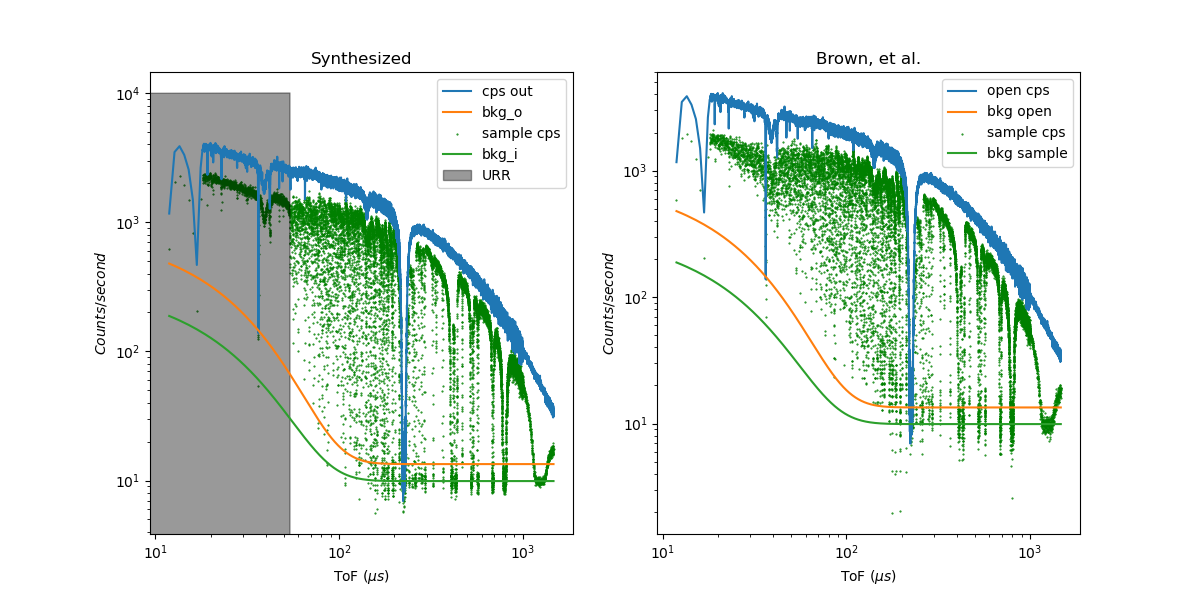

In [34]:
fig, ax = subplots(1,2, figsize=(12,6))

ax[0].plot(syndat_df.tof,syndat_df.co, label='cps out'); 
ax[0].plot(syndat_df.tof, syndat_df.bo, label='bkg_o')
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].scatter(syndat_df.tof,syndat_df.cs,marker='.', s=1, label='sample cps', color='g')
# ax[0].scatter(syndat_df.tof,syndat_df.theo_cts,marker='.', s=2, label='theo cts', color='k')
ax[0].plot(syndat_df.tof, syndat_df.bs, label='bkg_i')
# ax[0].set_ylim([10,1e4])
# ax[0].set_xlim([50,2e3])
ax[0].fill_between([0,54], [1e1,1e4], alpha=0.4, color='k', label='URR')

ax[0].set_title("Synthesized")
ax[0].legend(loc='upper right')
ax[0].set_xlabel('ToF ($\mu s$)')
ax[0].set_ylabel('$Counts/second$')



ax[1].plot(jb_df.tof,jb_df.co, label='open cps'); 
ax[1].plot(jb_df.tof, jb_df.bo, label='bkg open')
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].scatter(jb_df.tof,jb_df.cs,marker='.', s=1, label='sample cps', color='g'); 
ax[1].plot(jb_df.tof, jb_df.bs, label='bkg sample')
# ax[1].set_ylim([10,1e4])
# ax[1].set_xlim([50,2e3])
# ax[1].fill_between([0,54], [1e1,1e4], alpha=0.4, color='k', label='URR')

ax[1].set_title("Brown, et al.")
ax[1].legend(loc='upper right')
ax[1].set_xlabel('ToF ($\mu s$)')
ax[1].set_ylabel('$Counts/second$')

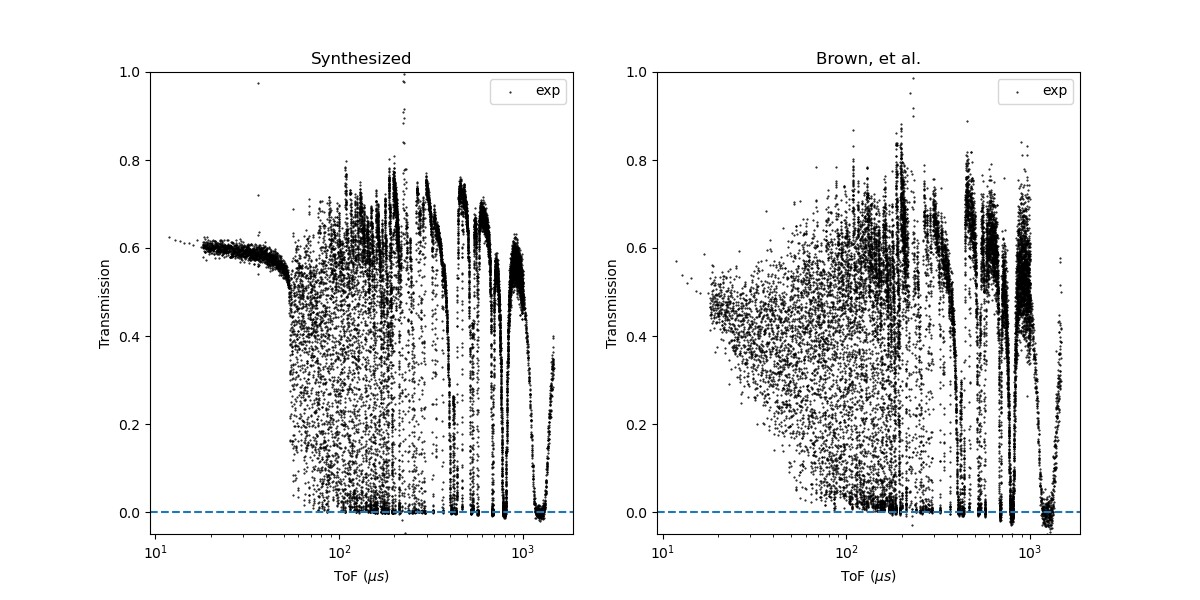

In [35]:

fig,ax = subplots(1,2, figsize=(12,6))
# suptitle('Theoretical and experimental transmission')

# ax[0].plot(syndat_df.tof,syndat_df.theo, lw=1,c='g', label='theo')
ax[0].scatter(syndat_df.tof,syndat_df.trans, marker='.', s=1, c='k', label='exp')
ax[0].set_xscale('log')
ax[0].set_ylim([-0.05,1])
ax[0].axhline(y=0.0, ls='--')
# ax[0].fill_between([0,54], [-0.05,1], alpha=0.4, color='k', label='URR')

ax[0].set_title("Synthesized")
ax[0].legend(loc='upper right')
ax[0].set_xlabel('ToF ($\mu s$)')
ax[0].set_ylabel('Transmission')
ax[0].legend()




# ax[1].plot(syndat_df.tof,syndat_df.theo, lw=1,c='g', label='theo')
ax[1].scatter(jb_df.tof, jb_df.trans, marker='.', color='k', s=1, label='exp')
# ax[1].errorbar(JBrown_lst.tof, JBrown_lst.exp_trans, yerr=JBrown_lst.exp_trans_unc, color='k',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3)
ax[1].set_xscale('log')
ax[1].axhline(y=0.0, ls='--')
ax[1].set_ylim([-0.05,1])
# ax[1].fill_between([0,54], [-0.05,1], alpha=0.4, color='k', label='URR')

ax[1].set_title('Brown, et al.')
ax[1].legend(loc='upper right')
ax[1].set_xlabel('ToF ($\mu s$)')
ax[1].set_ylabel('Transmission')
ax[1].legend()



# ax[0].set_xlim([10,3e3])
# ax[1].set_xlim([10,3e3])

# ax[0].set_xlim([175,200])
# ax[1].set_xlim([175,200])

# ax[1].set_xlim([145,185])
# ax[0].set_xlim([145,185])


In [37]:
# a_expdat_df = pd.DataFrame({'E':jb_df.e, 'expT':jb_df.trans, 'dT':np.sqrt(np.diag(jb_cov))})
# syndat.sammy_interface.write_expdat_file(a_expdat_df, "/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/bayes_solve/real.dat")

## Compare covariance matrix to Jesse's

This will give insight into whether or not the monitor normalizations have an effect

In [38]:
# import jesse's covariance 
jb_cov = np.load('/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_cov.npy')
syndat_cov = experiment.CovT
print(np.shape(syndat_cov))
print(np.shape(jb_cov))


(15915, 15915)
(15915, 15915)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


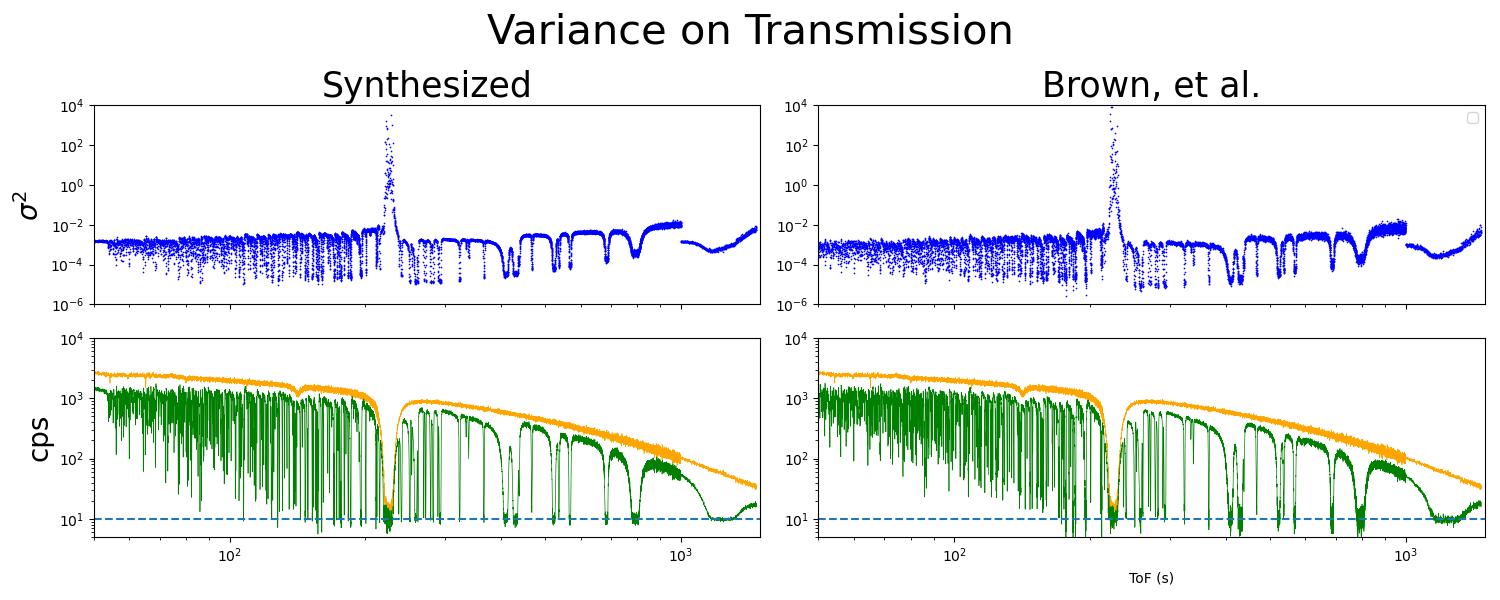

In [39]:
fig, (ax1, ax2) = subplots(2,2, gridspec_kw={'height_ratios': [1, 1]}, sharex=True, figsize=(15,6)) # , figsize=(12,5)

ax1[0].scatter(syndat_df.tof, np.diag(syndat_cov), lw=0.5, color='b', s=0.5, zorder=2)
ax1[0].set_ylim([1e-6,1e4])
ax1[0].set_xlim([50,1.5e3])
ax1[0].set_yscale('log')
ax1[0].set_title('Synthesized', size=25)
ax1[0].set_ylabel('$\sigma^2$', size=20); #('$\sigma$')

ax2[0].plot(syndat_df.tof, syndat_df.co, lw=0.5, c='orange')
ax2[0].plot(syndat_df.tof, syndat_df.cs, lw=0.5, c='g')
ax2[0].set_ylim([5,1e4])
ax2[0].axhline(y=10.0, ls='--')
ax2[0].set_ylabel('cps', size=20)
ax2[0].set_yscale('log')


ax1[1].scatter(jb_df.tof, np.diag(jb_cov), lw=0.5, color='b', s=0.5, zorder=2)
ax1[1].set_yscale('log')
ax1[1].set_ylim([1e-6,1e4])
ax1[1].set_xlim([50,1.5e3])
# ax1[1].set_ylabel('$\sigma^2$')
ax1[1].set_title('Brown, et al.', size=25)
ax1[1].legend()

ax2[1].plot(jb_df.tof, jb_df.co, lw=0.5, c='orange')
ax2[1].plot(jb_df.tof, jb_df.cs, lw=0.5, c='g')
ax2[1].set_ylim([5,1e4])
ax2[1].axhline(y=10.0, ls='--')
# ax2[1].set_ylabel('cps')
ax2[1].set_yscale('log')


xscale('log')
xlabel('ToF (s)');
suptitle('Variance on Transmission',size=30)
tight_layout()


(975, 975)
(975, 975)


Text(0.5, 1.0, 'Brown, et. al')

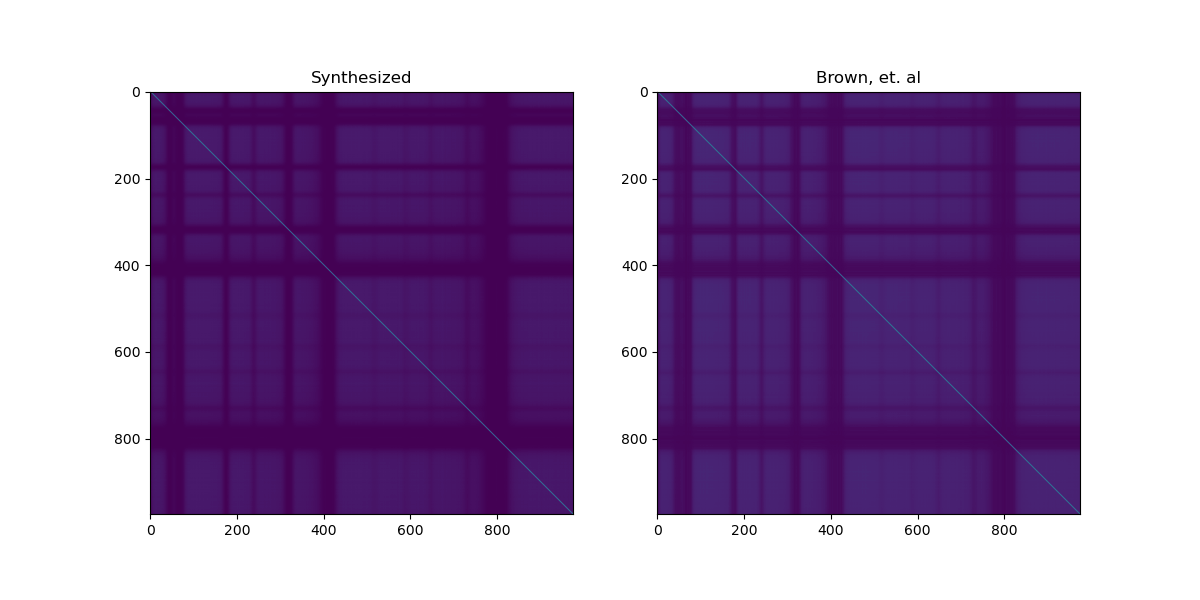

In [15]:
import matplotlib as mpl

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation


itof_min = np.argwhere(np.array(syndat_df.tof)>175)[0][0]
itof_max = np.argwhere(np.array(syndat_df.tof)<200)[-1][0]
jb_df_filtered = jb_df[itof_min:itof_max]
syndat_df_filtered = syndat_df[itof_min:itof_max]

jb_cov_filtered = jb_cov[itof_min:itof_max, itof_min:itof_max]
syndat_cov_filtered = syndat_cov[itof_min:itof_max, itof_min:itof_max]
print(np.shape(syndat_cov_filtered))
print(np.shape(jb_cov_filtered)) 


syndat_corr = correlation_from_covariance(syndat_cov_filtered)
jb_corr = correlation_from_covariance(jb_cov_filtered)

fig, ax = subplots(1,2, figsize=(12,6))
im1 = ax[0].imshow(syndat_corr)
ax[0].set_title("Synthesized")

im2 = ax[1].imshow(jb_corr)
ax[1].set_title("Brown, et. al")
# suptitle("Correlation Structure")

# cax = axes([0.85, 0.1, 0.075, 0.8])
# colorbar(mpl.cm.ScalarMappable(), ax=ax)
# cax = axes([0.85, 0.1, 0.075, 0.8])
# colorbar(im2)

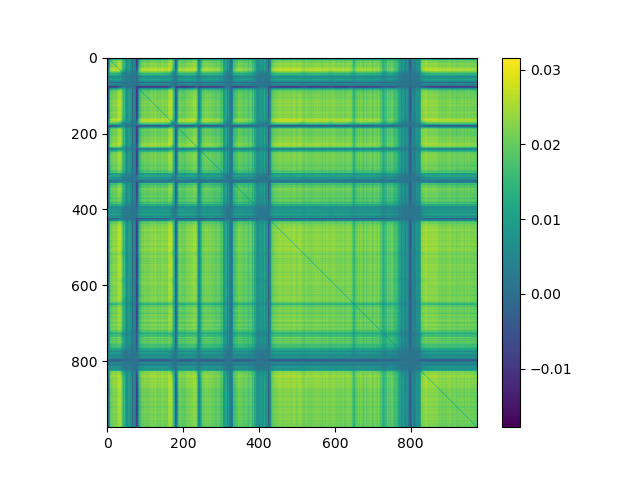

In [16]:
figure()
# imshow((jb_cov_filtered-syndat_cov_filtered))
imshow((jb_corr-syndat_corr))
colorbar()



In [17]:
# np.shape(jb_evec)
print(np.argwhere((jb_corr-syndat_corr) == max(((jb_corr-syndat_corr)).max(axis=1))))
print((jb_corr)[74,465])
print((syndat_corr)[74,465])

[[162 840]
 [840 162]]
0.021628075802458065
0.009986975804545684


In [18]:
# figure()
# plot(jb_df_filtered.tof, jb_evec[0])
# plot(syndat_df_filtered.tof, syndat_evec[0])
# # xscale('log')
# yscale('log')